In [ ]:
FOLD_SELECT = 0

In [ ]:
import os
import re
import math
import random
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as L

from sklearn.model_selection import KFold

In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
"""
%cd /content/gdrive/My Drive/kaggle/B4_512_perFold/
%ls
"""

/content/gdrive/My Drive/kaggle/B4_512_perFold
history_fold-0_model-b4_.csv           weights-1-10-0.900.h5
history_fold-1_model-b4_.csv           weights-1-15-0.908.h5
history_fold-2_model-b4_.csv           weights-1-20-0.920.h5
history_fold-3_model-b4_.csv           weights-1-25-0.923.h5
submission_fold-0_model-b4_TTA-10.csv  weights-2-05-0.799.h5
submission_fold-1_model-b4_TTA-10.csv  weights-2-10-0.872.h5
submission_fold-2_model-b4_TTA-10.csv  weights-2-15-0.908.h5
submission_fold-3_model-b4_TTA-10.csv  weights-2-20-0.913.h5
weights-0-05-0.814.h5                  weights-2-25-0.914.h5
weights-0-10-0.862.h5                  weights-3-05-0.717.h5
weights-0-15-0.870.h5                  weights-3-10-0.809.h5
weights-0-20-0.890.h5                  weights-3-15-0.859.h5
weights-0-25-0.899.h5                  weights-3-20-0.848.h5
weights-1-05-0.795.h5                  weights-3-25-0.851.h5


In [ ]:
"""
sub = []
for i in range(4):
  sub.append(pd.read_csv('submission_fold-%i_model-b4_TTA-10.csv' %i))

t = np.zeros(10982)
for i in range(4):
  t += sub[i].target
t /= 4

sub_f = sub[0].copy()
sub_f.target = t
sub_f.to_csv('sub_average.csv', index = False)

%ls
"""

history_fold-0_model-b4_.csv           weights-1-10-0.900.h5
history_fold-1_model-b4_.csv           weights-1-15-0.908.h5
history_fold-2_model-b4_.csv           weights-1-20-0.920.h5
history_fold-3_model-b4_.csv           weights-1-25-0.923.h5
sub_average.csv                        weights-2-05-0.799.h5
submission_fold-0_model-b4_TTA-10.csv  weights-2-10-0.872.h5
submission_fold-1_model-b4_TTA-10.csv  weights-2-15-0.908.h5
submission_fold-2_model-b4_TTA-10.csv  weights-2-20-0.913.h5
submission_fold-3_model-b4_TTA-10.csv  weights-2-25-0.914.h5
weights-0-05-0.814.h5                  weights-3-05-0.717.h5
weights-0-10-0.862.h5                  weights-3-10-0.809.h5
weights-0-15-0.870.h5                  weights-3-15-0.859.h5
weights-0-20-0.890.h5                  weights-3-20-0.848.h5
weights-0-25-0.899.h5                  weights-3-25-0.851.h5
weights-1-05-0.795.h5


In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
REPLICAS = strategy.num_replicas_in_sync

Running on TPU  grpc://10.56.74.194:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.56.74.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.74.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
DIM = 512
EPOCHS = 25
INITIAL_EPOCH = 0
NET_SELECT = 4
num_str = 'model-b4_'

INC2019 = 0
INC2018 = 1

TTA = 10

BATCH_SIZE = 8*strategy.num_replicas_in_sync

FOLDS = 5
idxT = []; idxV = []
LEN = np.arange(15)

SEED = 250
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SIZE= [DIM, DIM]   
WEIGHTS = 'noisy-student'

effnet = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, efn.EfficientNetB4, efn.EfficientNetB5,
          efn.EfficientNetB6, efn.EfficientNetB7]

In [ ]:
skf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
for fold,(idx_t,idx_val) in enumerate(skf.split(np.arange(15))):
    if fold == FOLD_SELECT:
        idxT = idx_t
        idxV = idx_val

In [ ]:
print('Validation index: ', idxV)

Validation index:  [0 7 9]


In [ ]:
GCS_PATH1 = 'gs://kds-154649568d837568b1118f54c8293475e4b9686f2f6b0d89c6a2183e'
GCS_PATH2 = 'gs://kds-823a9066a531d4a2cb81f281a88a2235b28df4699c8eaf2a0b1f5208'

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH1 + '/train%.2i*.tfrec' %x for x in idxT)
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH1 + '/train%.2i*.tfrec' %x for x in idxV)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH1 + '/test*.tfrec')

if INC2019:
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_PATH2 + '/train%.2i*.tfrec' %x for x in LEN*2 + 1])
if INC2018:
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_PATH2 + '/train%.2i*.tfrec'%x for x in LEN*2])

In [ ]:
print('Number of training files: ', len(TRAINING_FILENAMES))

Number of training files:  27


In [ ]:
train_1 = pd.read_csv('/content/gdrive/My Drive/kaggle/jpeg-melanoma-768x768/train.csv')
train_2 = pd.read_csv('/content/gdrive/My Drive/kaggle/jpeg-isic2019-768x768/train.csv')

train = pd.DataFrame(pd.concat([train_1, train_2]))
Y = pd.DataFrame(pd.concat([train_1.target, train_2.target]))

In [ ]:
mean = train.age_approx.mean()
std = train.age_approx.std()

In [ ]:
%cd /content/gdrive/My Drive/kaggle/B4_512_perFold/

/content/gdrive/My Drive/kaggle/B4_512_perFold


In [ ]:
%ls

history_fold-0_model-b4_.csv           weights-1-05-0.795.h5
history_fold-1_model-b4_.csv           weights-1-10-0.900.h5
history_fold-2_model-b4_.csv           weights-1-15-0.908.h5
submission_fold-0_model-b4_TTA-10.csv  weights-1-20-0.920.h5
submission_fold-1_model-b4_TTA-10.csv  weights-1-25-0.923.h5
submission_fold-2_model-b4_TTA-10.csv  weights-2-05-0.799.h5
weights-0-05-0.814.h5                  weights-2-10-0.872.h5
weights-0-10-0.862.h5                  weights-2-15-0.908.h5
weights-0-15-0.870.h5                  weights-2-20-0.913.h5
weights-0-20-0.890.h5                  weights-2-25-0.914.h5
weights-0-25-0.899.h5


In [ ]:
def prepare_image(data, augment = False):
    image = data['CNN_inp']
    
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    
    if augment:
        image = transform(image)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.1)
    
    data['CNN_inp'] = image
    return data

In [ ]:
tab_feats = [
    'sex',
    'age_approx',
]

N_TAB_FEATS = len(tab_feats)

def setup_input(image, label, data):
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in tab_feats]
    tabular = tf.stack(tab_data)
    return {'CNN_inp': image, 'TAB_inp':  tabular}, label

def setup_test_image(image, image_name, data):    
    tab_data = [tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular = tf.stack(tab_data)
    return {'CNN_inp': image, 'TAB_inp':  tabular}, image_name

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string), # shape [] means single element
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64),  
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = example['image']
    label = tf.cast(example['target'], tf.int32)
    
    data = {}
    data['image_name'] = tf.cast(example['image_name'], tf.string)
    data['sex'] = tf.cast(example['sex'], tf.int64)
    data['age_approx'] = (tf.cast(example['age_approx'], tf.float32) - mean)/std
    
    return image, label, data

In [ ]:
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    
    image = example['image']
    image_name = example['image_name']
    
    data = {}
    data['image_name'] = image_name
    data['sex'] = tf.cast(example['sex'], tf.int64)
    data['age_approx'] = (tf.cast(example['age_approx'], tf.float32) - mean)/std
    
    return image, image_name, data

In [ ]:
def get_dataset(files, augmented = False, shuffle = False, repeat = False, labeled = False):
    
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads = AUTO)
    dataset = dataset.cache()
    
    if repeat:
        dataset = dataset.repeat()
        
    if shuffle: 
        dataset = dataset.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    if labeled:
        dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO)
        dataset = dataset.map(setup_input, num_parallel_calls = AUTO)
    else:
        dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls = AUTO)
        dataset = dataset.map(setup_test_image, num_parallel_calls = AUTO)
    
    dataset = dataset.map(lambda data, imagename_or_label : (prepare_image(data, augment = augmented), imagename_or_label),
                          num_parallel_calls = AUTO)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [ ]:
####variables to set extent of image augmentation.
ROT_ = 90.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies

    def get_3x3_mat(mat):
        return tf.reshape(tf.concat([mat], axis = 0), [3, 3])
    
    # ROTATION MATRIX
    cos = tf.math.cos(rotation)
    sin = tf.math.sin(rotation)
    one = tf.constant([1], dtype = 'float32')
    zero = tf.constant([0], dtype = 'float32')
    
    rotation_matrix = get_3x3_mat([cos, sin ,zero,
                                   -sin, cos, zero,
                                   zero, zero, one])        
           
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero, zero,
                               zero, one/width_zoom, zero, 
                               zero, zero, one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one, zero, height_shift, 
                                zero, one, width_shift, 
                                zero, zero, one])
    
    return tf.keras.backend.dot(rotation_matrix, tf.keras.backend.dot(zoom_matrix, shift_matrix))

def transform(image):
    XDIM = DIM%2
    
    rot = ROT_*tf.random.uniform([1])
    rot = math.pi*rot/180.
    
    h_zoom = 1.0 + tf.random.normal([1], dtype = 'float32')/HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype = 'float32')/WZOOM_
    h_shift = HSHIFT_*tf.random.normal([1], dtype = 'float32') 
    w_shift = WSHIFT_*tf.random.normal([1], dtype = 'float32')
    
    m = get_mat(rot, h_zoom, w_zoom, h_shift, w_shift)

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM//2, -DIM//2, -1), DIM)
    y = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z = tf.ones([DIM*DIM], dtype = 'int32')
    idx = tf.stack([x,y,z])
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.keras.backend.dot(m, tf.cast(idx, dtype = 'float32'))
    idx2 = tf.keras.backend.cast(idx2, dtype = 'int32')
    idx2 = tf.keras.backend.clip(idx2, -DIM//2 + XDIM + 1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2 - idx2[0, ], DIM//2 - 1 + idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d, [DIM, DIM, 3])

In [ ]:
def get_training_dataset():
    dataset = get_dataset(TRAINING_FILENAMES,
                          augmented = True,
                          shuffle = True,
                          repeat = True,
                          labeled = True)
    return dataset

def get_validation_dataset():
    dataset = get_dataset(VALIDATION_FILENAMES,
                          augmented = False,
                          shuffle = False,
                          repeat = False,
                          labeled = True)
    return dataset

def get_test_dataset(ordered = True):
    dataset = get_dataset(TEST_FILENAMES,
                          augmented = True,
                          shuffle = False,
                          repeat = True,
                          labeled = False)
    return dataset

In [ ]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 39017 training images, 6534 validation images, 10982 unlabeled test images


In [ ]:
neg, pos = np.bincount(Y.target)

initial_bias = np.log(pos/neg)

weight_for_0 = (1 / neg)*(pos + neg)/2.0 
weight_for_1 = (1 / pos)*(pos + neg)/2.0
classweights = {0: weight_for_0, 1: weight_for_1}

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [ ]:
"""
import time

start = time.time()
for i, batch in enumerate(get_training_dataset()):
    print(i, ', ', end = '')
    if i >= STEPS_PER_EPOCH:
        break
        
print('Elapsed time seconds = ', (time.time()-start))
"""
print('To check data loading time.')

To check data loading time.


In [ ]:
"""
def display_augmentation(train_batch, n_samples = 5, rows = 1, cols = 7):
    
    dataset_elements = iter(train_batch)
    
    for sample in range(n_samples):
        elements = tf.data.Dataset.from_tensors(next(dataset_elements))
        one_image_batch = elements.repeat().batch(rows*cols)
        
        for image, label_or_name in one_image_batch:
            results = map(transform, image['CNN_inp'])
            plt.figure(figsize=(15, int(15*rows/cols)))
            for i, img in enumerate(list(results)):
                plt.subplot(1, 7, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
            break
            
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch()
train_batch = iter(training_dataset)

display_augmentation(train_batch)
"""
print('To see images')

To see images


In [ ]:
with strategy.scope():
    METRICS = [
      tf.keras.metrics.TruePositives(name = 'tp'),
      tf.keras.metrics.FalseNegatives(name = 'fn'), 
      tf.keras.metrics.AUC(name = 'auc'),
    ]

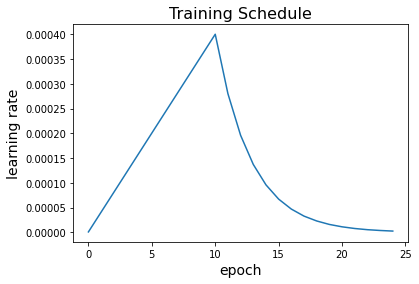

In [ ]:
# CUSTOM LEARNING SCHEUDLE - exponential
lr_start = 0.000001
lr_max = 0.00005*REPLICAS
lr_min = 0.000001
start_epoch = 0
rampup_epoch = 10
sustain_epoch = 10
lr_exp_decay = 0.70

def lrfn(epoch):
    if epoch < start_epoch :
        lr = lr_start
    elif epoch < rampup_epoch :
        lr = ((lr_max - lr_start)/(rampup_epoch - start_epoch))*(epoch - start_epoch) + lr_start
    elif epoch < sustain_epoch :
            lr = lr_max
    else:
            lr = lr_max*(lr_exp_decay**(epoch - sustain_epoch) + lr_min)
            
    return round(lr, 7)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = 1)

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size = 14); plt.ylabel('learning rate',size = 14)
plt.title('Training Schedule', size = 16); plt.show()

In [ ]:
checkpoint_path = 'weights-%i-{epoch:02d}-{val_auc:.3f}.h5'%FOLD_SELECT
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor = 'val_auc',
                                                verbose = 1,
                                                save_weights_only = True,
                                                period = 5)

In [ ]:
def build_model():
    with strategy.scope():
        eff_model = effnet[NET_SELECT](
            input_shape = (*IMAGE_SIZE, 3),
            weights = WEIGHTS,
            include_top = False
        )
        eff_model.trainable = True
        
        CNN_inp = L.Input(shape = (*IMAGE_SIZE, 3), name = 'CNN_inp')
        TAB_inp = L.Input(shape = (N_TAB_FEATS), name = 'TAB_inp')
        
        x = eff_model(CNN_inp)
        x = L.GlobalMaxPooling2D()(x)
        x = L.Dense(1024, activation = 'relu')(x)
        x = L.Dropout(0.3)(x)
        x = L.Dense(512, activation = 'relu')(x)
        x = L.Dropout(0.2)(x)
        x = L.Dense(256, activation ='relu')(x)
        x = L.Dropout(0.2)(x)
        x = L.Dense(128, activation ='relu')(x)
        x = L.Dropout(0.1)(x)
        x = L.Dense(30, activation ='relu')(x)
        x = L.Dropout(0.1)(x)
        
        y = L.Dense(8, activation = 'relu')(TAB_inp)
        y = L.Dropout(0.1)(y)
        y = L.Dense(2, activation ='relu')(y)
        y = L.Dropout(0.1)(y)
        
        combine = L.concatenate([y, x])
        
        output = L.Dense(1, activation ='sigmoid',
                         bias_initializer = tf.keras.initializers.Constant(initial_bias),
                         name = 'output')(combine)
        
        model = tf.keras.models.Model(inputs = [CNN_inp, TAB_inp], outputs = [output])
    
    return model

model = build_model()

model.summary()

71680000/71678424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN_inp (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b4 (Model)         (None, 16, 16, 1792) 17673816    CNN_inp[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1792)         0           efficientnet-b4[1][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         1836032     global_max_pooling2d[0][0]       
_____________________________

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tfa.losses.SigmoidFocalCrossEntropy(gamma = 5.0, alpha = 0.2),
    metrics = METRICS
)

In [ ]:
history = model.fit(
    get_training_dataset(), 
    epochs = EPOCHS, 
    initial_epoch = INITIAL_EPOCH,
    steps_per_epoch = STEPS_PER_EPOCH,
    class_weight = classweights,
    validation_data = get_validation_dataset(),
    callbacks = [lr_schedule, checkpoint]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/25
609/609 [==============================] - 260s 427ms/step - auc: 0.5067 - loss: 0.1652 - tp: 401.0000 - fn: 1635.0000 - val_auc: 0.5652 - val_loss: 0.0061 - val_tp: 0.0000e+00 - val_fn: 116.0000 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 4.09e-05.
Epoch 2/25
609/609 [==============================] - 231s 380ms/step - auc: 0.5332 - loss: 0.0354 - tp: 353.0000 - fn: 1779.0000 - val_auc: 0.6056 - val_loss: 0.0015 - val_tp: 0.0000e+00 - val_fn: 116.0000 - lr: 4.0900e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 8.08e-05.
Epoch 3/25
609/609 [==============================] - 232s 382ms/step - auc: 0.5833 - loss: 0.0143 - tp: 381.0000 - fn: 1715.0000 - val_auc: 0.6761 - val_loss: 0.0013 - val_tp: 0.0000e+00 - val_fn: 116.0000 - lr: 8.0800e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001207.
Epoch 4/25
609/609 [======================

In [ ]:
pd.DataFrame.from_dict(history.history).to_csv('history_fold-%i_' %FOLD_SELECT + num_str + '.csv', index = False)

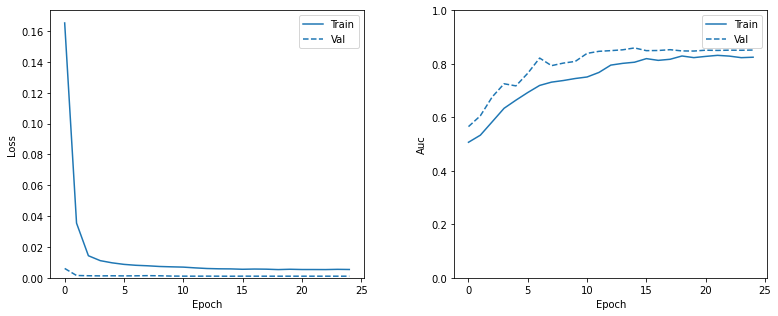

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

def plot_metrics(history):
  metrics =  ['loss', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n + 1)
    
    plt.plot(history.epoch, history.history[metric], color = colors[0], label = 'Train')
    plt.plot(history.epoch, history.history['val_' + metric], color = colors[0], linestyle = "--", label = 'Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)
    
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.0,1])
        
    plt.legend()
    plt.tight_layout(pad = 5)

plot_metrics(history)

In [ ]:
if FOLD_SELECT >= 0:
    STEPS = TTA*NUM_TEST_IMAGES/BATCH_SIZE
    testtf = get_test_dataset()
    test_images_ds = testtf.map(lambda data, image_name : data)

    pred = model.predict(test_images_ds, steps = STEPS, verbose = 1)[:TTA*NUM_TEST_IMAGES, ] 

    preds = np.zeros((NUM_TEST_IMAGES, 1))
    preds[:, 0] = np.mean(pred.reshape((NUM_TEST_IMAGES, TTA), order = 'F'), axis = 1)

    test_ids_ds = testtf.map(lambda image, image_name : image_name).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

    submission = pd.DataFrame(dict(image_name = test_ids, target = preds[:, 0]))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission_fold-%i_' %FOLD_SELECT + num_str + 'TTA-10.csv' , index = False)

1716/1715 [==============================] - 194s 113ms/step


In [ ]:
submission

,image_name,target
9905,ISIC_0052060,0.262988
1443,ISIC_0052349,0.241960
3120,ISIC_0058510,0.242915
4870,ISIC_0073313,0.213293
5494,ISIC_0073502,0.273679
...,...,...
5994,ISIC_9992485,0.262364
3980,ISIC_9996992,0.270393
6974,ISIC_9997917,0.299268
1278,ISIC_9998234,0.251556


In [ ]:
%ls

history_fold-0_model-b4_.csv           weights-1-10-0.900.h5
history_fold-1_model-b4_.csv           weights-1-15-0.908.h5
history_fold-2_model-b4_.csv           weights-1-20-0.920.h5
history_fold-3_model-b4_.csv           weights-1-25-0.923.h5
submission_fold-0_model-b4_TTA-10.csv  weights-2-05-0.799.h5
submission_fold-1_model-b4_TTA-10.csv  weights-2-10-0.872.h5
submission_fold-2_model-b4_TTA-10.csv  weights-2-15-0.908.h5
submission_fold-3_model-b4_TTA-10.csv  weights-2-20-0.913.h5
weights-0-05-0.814.h5                  weights-2-25-0.914.h5
weights-0-10-0.862.h5                  weights-3-05-0.717.h5
weights-0-15-0.870.h5                  weights-3-10-0.809.h5
weights-0-20-0.890.h5                  weights-3-15-0.859.h5
weights-0-25-0.899.h5                  weights-3-20-0.848.h5
weights-1-05-0.795.h5                  weights-3-25-0.851.h5
